In [1]:
import sys
import itertools
import pathlib
import numpy
import scipy.interpolate
import ipywidgets
import pandas
from h5py import File as h5open
from cycler import cycler
from matplotlib import pyplot
from matplotlib import colors
from matplotlib import ticker
from matplotlib.legend_handler import HandlerTuple

In [2]:
# find helpers and locate workdir
for parent in [pathlib.Path.cwd()] + list(pathlib.Path.cwd().parents):
    if parent.joinpath("modulus").is_dir():
        projdir = parent
        sys.path.insert(0, str(projdir.joinpath("modulus")))
        from helpers.utils import read_tensorboard_data  # pylint: disable=import-error
        from helpers.lr_simulator import widget as lr_widget
        from helpers.utils import log_parser  # pylint: disable=import-error
        break
else:
    raise FileNotFoundError("Couldn't find module `helpers`.")

# point workdir to the correct folder
workdir = projdir.joinpath("modulus", "tgv-2d-re100")
petibmdir = projdir.joinpath("petibm", "taylor-green-vortex-2d-re100")
figdir = workdir.joinpath("figures")
figdir.mkdir(exist_ok=True)

In [3]:
# unified figure style
pyplot.style.use(projdir.joinpath("resources", "figstyle"))

In [4]:
# parameters
nls = [1, 2, 3]
nns = [16, 32, 64, 128, 256]
nbss = [1024, 2048, 4096, 8192, 16384, 32768, 65536]

In [85]:
from re import I


def get_best_med_worst_base_cases():
    """Get the cases with the best, median, and the worst errors.
    """
    bestl2norm = float("inf")
    best = None
    errs = []
    cases = []
    for nl, nn, nbs in itertools.product(nls, nns, nbss):
        with h5open(workdir.joinpath("outputs", "base-cases", f"nl{nl}-nn{nn}-npts{nbs}-raw.h5"), "r") as h5file:
            errs.append(float(h5file[f"sterrs/u/l2norm"][...]))
        cases.append((nl, nn, nbs))
    
    errs = numpy.array(errs)
    cases = numpy.array(cases, dtype=object)

    besterr = numpy.min(errs)
    bestconf = cases[numpy.argmin(errs)]
    worsterr = numpy.max(errs)
    worstconf = cases[numpy.argmax(errs)]
    mederr = numpy.median(errs)
    medconf = cases[numpy.where(errs == mederr)[0][0]]
    
    return (besterr, bestconf), (mederr, medconf), (worsterr, worstconf)

In [6]:
def get_worst_base_case():
    """Plot figures for the case performed the best for averaged spatial-temporal error.
    """
    worstl2norm = - float("inf")
    worst = None
    for nl, nn, nbs in itertools.product(nls, nns, nbss):
        with h5open(workdir.joinpath("outputs", "base-cases", f"nl{nl}-nn{nn}-npts{nbs}-raw.h5"), "r") as h5file:
            err = float(h5file[f"sterrs/u/l2norm"][...])
        
        if err > worstl2norm:
            worstl2norm = err
            worst = (nl, nn, nbs)
    return worst, worstl2norm

In [86]:
(besterr, bestconf), (mederr, medconf), (worsterr, worstconf) = get_best_med_worst_base_cases()
print(f"raw, (best case, err): {besterr}, {bestconf}")
print(f"raw, (median case, err): {mederr}, {medconf}")
print(f"raw, (worst case, err): {worsterr}, {worstconf}")

raw, (best case, err): 0.00832254538297106, [3 256 4096]
raw, (median case, err): 0.1381084722210188, [2 32 65536]
raw, (worst case, err): 0.3108040850982813, [1 32 16384]


In [65]:
def plot_base_case_training_history(workdir, h5dir, figdir, nl, nn, nbs, ws):
    """Plot figures related to training loss and spatial-temporal errors.
    """

    data = log_parser(workdir.joinpath(f"nl{nl}-nn{nn}-npts{nbs}"))

    with h5open(h5dir.joinpath(f"nl{nl}-nn{nn}-npts{nbs}-raw.h5"), "r") as h5file:
        errsteps = h5file["walltime/steps"][...]
        errtimes = h5file["walltime/elapsedtimes"][...]
        err = [
            h5file["walltime/l2norms/u/0.0"][...],
            h5file["walltime/l2norms/u/40.0"][...],
            h5file["walltime/l2norms/u/80.0"][...],
        ]

    # plot according to optimizer type
    fig, ax = pyplot.subplots(1, 1, sharex=False, sharey=False, figsize=(8, 4))
    fig.suptitle(rf"2D TGV, $Re=100$, $(N_l, N_n, N_{{bs}})=({nl}, {nn}, {nbs})$")
    
    # loss against steps
    ax.set_title("Training loss and solution errors v.s. iterations")
    l1, = ax.semilogy(data.index, data.loss, alpha=0.3, lw=0.5, label="Raw data")
    l2, = ax.semilogy(data.index, data.loss.rolling(window=ws).mean(), lw=1.5, label="Moving avg.")
    l3, = ax.semilogy(data.index, data.loss.rolling(window=ws).min(), lw=1.5, label="Moving min.")
    l4, = ax.semilogy(errsteps, err[0], lw=1, ls="--", label=r"$t=0$")
    l5, = ax.semilogy(errsteps, err[1], lw=1, ls="--", label=r"$t=40$")
    l6, = ax.semilogy(errsteps, err[2], lw=1, ls="--", label=r"$t=80$")
    ax.set_xlabel("Iteration")
    ax.set_ylabel(r"Loss or $L_2$ error")
    ax.grid()
    
    # legends
    lgd1 = ax.legend(
        handles=[l1, l2, l3], title="Aggregated loss",
        loc="upper right", bbox_to_anchor=(0.99, 0.99)
    )
    lgd2 = ax.legend(
        handles=[l4, l5, l6], title=r"$L_2$ error of $u$",
        loc="upper right", bbox_to_anchor=(0.79, 0.99)
    )
    ax.add_artist(lgd1)

    # time axis / errors
    axerr = ax.twiny()
    axerr.semilogy(errtimes, err[0], lw=0)  # dummy line to set x-axis limits
    axerr.spines["bottom"].set_position(("axes", -0.3))
    axerr.spines["bottom"].set_visible(True)
    axerr.xaxis.set_label_position("bottom")
    axerr.xaxis.set_ticks_position("bottom")
    axerr.set_xlabel("Run time (hours)")
    axerr.get_xaxis().set_ticks_position("bottom")

    # save
    figdir.joinpath("training-hist").mkdir(parents=True, exist_ok=True)
    fig.savefig(figdir.joinpath("training-hist", f"nl{nl}-nn{nn}-npts{nbs}.png"))
    # pyplot.close(fig)

In [66]:
# plot case training history
option1 = ipywidgets.Dropdown(options=nls, value=3)
option2 = ipywidgets.Dropdown(options=nns, value=256)
option3 = ipywidgets.Dropdown(options=nbss, value=1024)
option4 = ipywidgets.IntSlider(value=10, min=1, max=200, step=2, orientation="horizontal") 
canvas = ipywidgets.interactive_output(
    plot_base_case_training_history,
    {
        "workdir": ipywidgets.fixed(workdir.joinpath("base-cases")),
        "h5dir": ipywidgets.fixed(workdir.joinpath("outputs", "base-cases")),
        "figdir": ipywidgets.fixed(figdir.joinpath("base-cases")),
        "nl": option1, "nn": option2, "nbs": option3, "ws": option4,
    }
)

out = ipywidgets.VBox([option1, option2, option3, option4, canvas])
display(out)

In [88]:
def plot_base_case_contour(nl, nn, nbs, time, workdir, figdir):
    """Plot figures for the case performed the best at t=40.
    """

    with h5open(workdir.joinpath(f"nl{nl}-nn{nn}-npts{nbs}-raw.h5"), "r") as h5file:
        coords = (h5file["field/x"][...], h5file["field/y"][...])

        vals = {
            r"$u$": h5file[f"field/{time}/u"][...],
            r"$v$": h5file[f"field/{time}/v"][...],
            r"$p$": h5file[f"field/{time}/p"][...],
            r"$\omega_z$": h5file[f"field/{time}/vorticity_z"][...],
        }

        errs = {
            r"$u$": h5file[f"field/{time}/err-u"][...],
            r"$v$": h5file[f"field/{time}/err-v"][...],
            r"$p$": h5file[f"field/{time}/err-p"][...],
            r"$\omega_z$": h5file[f"field/{time}/err-vorticity_z"][...],
        }

    # re-cal. the pressure w/ the mean from analytical soln. as it is assumed to have a constant shift
    ptrue = numpy.exp(-4.*0.01*float(time)) * (numpy.cos(2.*coords[0]) + numpy.cos(2.*coords[1])) / 4.
    vals[r"$p$"] = vals[r"$p$"] - vals[r"$p$"].mean()
    errs[r"$p$"] = abs(vals[r"$p$"] - ptrue)

    fig, axs = pyplot.subplots(4, 2, sharex=True, sharey=True, figsize=(8.5, 13))

    fig.suptitle(
        rf"Flow and errors, TGV 2D@$t={float(time)}$, $Re=100$, "+"\n" +
        rf"$(N_l, N_n, N_{{bs}})=({nl}, {nn}, {nbs})$"
    )

    for i, field in enumerate([r"$u$", r"$v$", r"$p$", r"$\omega_z$"]):
        # field values
        ct = axs[i, 0].contourf(*coords, vals[field], 16)
        axs[i, 0].set_aspect("equal")
        axs[i, 0].set_title(field)
        fig.colorbar(ct, ax=axs[i, 0])

        # errors
        ct = axs[i, 1].contourf(
            *coords, errs[field], 16,
            norm=colors.LogNorm(vmin=errs[field].min(), vmax=errs[field].max())
        )
        axs[i, 1].set_aspect("equal")
        axs[i, 1].set_title(f"Absolute error, {field}")
        fmt = ticker.LogFormatter()                                                                                     
        cbar = fig.colorbar(ct, ax=axs[i, 1], format=fmt)
    
    axs[0, 0].set_ylabel(r"$y$")
    axs[1, 0].set_ylabel(r"$y$")
    axs[2, 0].set_ylabel(r"$y$")
    axs[3, 0].set_ylabel(r"$y$")
    axs[3, 0].set_xlabel(r"$x$")
    axs[3, 1].set_xlabel(r"$x$")

    figdir.joinpath("contours").mkdir(parents=True, exist_ok=True)
    pyplot.savefig(figdir.joinpath("contours", f"nl{nl}-nn{nn}-npts{nbs}-t{time}.png"))

In [89]:
# plot contours for cases
option1 = ipywidgets.Dropdown(options=nls, value=3)
option2 = ipywidgets.Dropdown(options=nns, value=256)
option3 = ipywidgets.Dropdown(options=nbss, value=1024)
option4 = ipywidgets.Dropdown(options=["0.0", "40.0", "80.0"], value="40.0")
canvas = ipywidgets.interactive_output(
    plot_base_case_contour,
    {
        "nl": option1, "nn": option2, "nbs": option3, "time": option4,
        "workdir": ipywidgets.fixed(workdir.joinpath("outputs", "base-cases")),
        "figdir": ipywidgets.fixed(figdir.joinpath("base-cases"))
    }
)
display(ipywidgets.VBox([option1, option2, option3, option4, canvas]))

In [90]:
def plot_err_arch_boxplot(field, workdir, figdir):
    """plot_err_arch_boxplot
    """
    data = {"nl": [], "nn": [], "nbs": [], "l2norm": []}
    for nl, nn, nbs in itertools.product(nls, nns, nbss):
        data["nl"].append(nl)
        data["nn"].append(nn)
        data["nbs"].append(nbs)
        with h5open(workdir.joinpath(f"nl{nl}-nn{nn}-npts{nbs}-raw.h5"), "r") as h5file:
            data["l2norm"].append(float(h5file[f"sterrs/{field}/l2norm"][...]))

    data = pandas.DataFrame(data)
    data = data.pivot(index="nbs", columns=["nl", "nn"], values="l2norm")
    data = data[data.mean().sort_values(ascending=False).index]

    fig, ax = pyplot.subplots(1, 1)
    fig.suptitle(r"Error distribution across network architectures")

    ax.boxplot(
        data.values, labels=data.columns, showmeans=True,
        meanprops={"marker": ".", "mfc": "k", "mec": "k"},
        medianprops={"ls": "none"},
    )
    ax.tick_params(axis="x", labelrotation=45)
    ax.set_xlabel(r"$(N_l, N_n)$")
    ax.set_ylabel(rf"$L_2$-norm of ${field}$")
    ax.set_yscale("log")

    figdir.joinpath("err-vs-arch").mkdir(parents=True, exist_ok=True)
    fig.savefig(figdir.joinpath("err-vs-arch", f"err-arch-boxplot-{field}.png"))

In [92]:
# plot error vs. network arch
option1 = ipywidgets.Dropdown(options=["u", "v"], value="u", description="Velocity")
canvas = ipywidgets.interactive_output(
    plot_err_arch_boxplot,
    {
        "field": option1,
        "workdir": ipywidgets.fixed(workdir.joinpath("outputs", "base-cases")),
        "figdir": ipywidgets.fixed(figdir.joinpath("base-cases"))
    }
)
out = ipywidgets.HBox([canvas, option1])
display(out)

In [96]:
def dof_calculator(nl, nn, dim=2, unsteady=True, periodic=True):
    """Degree of freedom calculator.
    """
    ninp = dim + int(unsteady) + 2 * int(periodic)
    dof = ninp * nn + 2 * nn
    dof += (nn**2 + 2 * nn) * (nl - 1)
    dof += (nn + 1) * (dim + 1) 
    return dof

34563

dofs     163       323       451       643       739       1283      1411    \
nbs                                                                           
1024   0.306828  0.308421  0.308273  0.305086  0.205081  0.304455  0.180026   
2048   0.310451  0.309692  0.308818  0.305589  0.289769  0.306305  0.207736   
4096   0.306599  0.310460  0.306982  0.306574  0.220198  0.298597  0.107979   
8192   0.309194  0.307541  0.307407  0.307287  0.302942  0.289407  0.216887   
16384  0.309923  0.310804  0.308187  0.307641  0.306397  0.293620  0.121877   
32768  0.307441  0.308706  0.307983  0.305914  0.307573  0.305106  0.116708   
65536  0.308511  0.309357  0.307545  0.306308  0.225712  0.303419  0.138108   

dofs     2499      2563      4867      9091      17923     34563     68611   \
nbs                                                                           
1024   0.057610  0.283306  0.039645  0.020087  0.019361  0.014656  0.013667   
2048   0.055210  0.279008  0.048219  0.022351  0.01

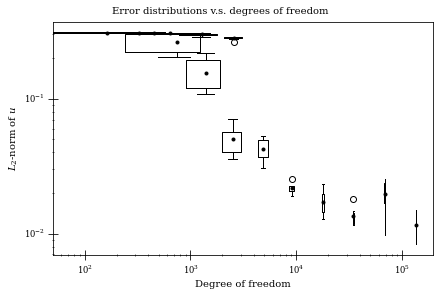

In [116]:
def plot_dof_err(field, workdir, figdir):
    """plot_dof_err
    """
    data = {"dofs": [], "l2norm": [], "nbs": []}
    for nl, nn, nbs in itertools.product(nls, nns, nbss):
        data["nbs"].append(nbs)
        data["dofs"].append(dof_calculator(nl, nn, 2, True, True))
        with h5open(workdir.joinpath(f"nl{nl}-nn{nn}-npts{nbs}-raw.h5"), "r") as h5file:
            data["l2norm"].append(float(h5file[f"sterrs/{field}/l2norm"][...]))

    data = pandas.DataFrame(data)
    data = data.pivot(index="nbs", columns=["dofs"], values="l2norm")
    data = data.sort_index(axis=1)

    # box widths on the plot with log x axis
    width = lambda p, w: 10**(numpy.log10(p)+w/2.)-10**(numpy.log10(p)-w/2.)

    fig, ax = pyplot.subplots(1, 1)
    fig.suptitle(r"Error distributions v.s. degrees of freedom")

    ax.boxplot(
        data.values, labels=data.columns, positions=data.columns,
        showmeans=True, widths=width(data.columns, 1),
        meanprops={"marker": ".", "mfc": "k", "mec": "k"},
        medianprops={"ls": "none"},
    )

    ax.set_xlabel("Degree of freedom")
    ax.set_xscale("log")

    ax.set_ylabel(rf"$L_2$-norm of ${field}$")
    ax.set_yscale("log")

    # figdir.joinpath("err-vs-arch").mkdir(parents=True, exist_ok=True)
    # fig.savefig(figdir.joinpath("err-vs-arch", f"err-arch-boxplot-{field}.png"))

plot_dof_err("u", workdir.joinpath("outputs", "base-cases"), figdir.joinpath("base-cases"))

In [14]:
# display(lr_widget())